## Mitigating extreme energy events with ML

If not yet viewed, please refer to the 'kolmogorov_demo.ipynb' to better understand the extreme energy events in a kolmogorov flow simulation. In this notebook, ML techniques will be used to: 

1. Predict $\textit{when}$ an extreme event will occur based on the energy values of the most "important" modes through a neural network

2. Use a Deep Deterministic Policy Gradient algorithm to try to learn an agent in the form of: $a_1 sin(k_1 y) + a_2 sin(k_2 y) + a_3 sin(k_3 y) + ... $ 

While we do have a general understanding of what causes the extreme event (transfer of energy between a specific larger structure mode to a smaller structure mode of the same wavenumber of the forcing), we are taking the naive approach. In reality, we might not know when an event will happen or what will cause it, so ML will help us fill these gaps! 

### Neural Network for predicting when an event will occur based on the energy of the first ~10% of modes

We know that a turbulent system follows an energy cascade, in which most of the energy is contained in the large-scale structures (low wavenumber modes) which get transferred to smaller scales (higher wavenumbers) and eventually get dissipated into heat.  

In [9]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Generate simple feed forward neural network

In [4]:

class PredictEnergyEvent(nn.Module):
    """
    Neural network for predicting the occurance of extreme event.
    """
    def __init__(self, data_size):
        super(PredictEnergyEvent, self).__init__()
        self.fc1 = nn.Linear(data_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

### Split train and test data

In [6]:
# Split data into training and testing sets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

test_percentage = 0.2
X = np.load('full_train.npy')
y = np.load('labels.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.optim as optim

model = PredictEnergyEvent(400)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_model = 'predict_event.pth'

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()  
        loss = criterion(outputs, y_batch.squeeze()) 
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), save_model)

### Evaluate model on unseen environment 

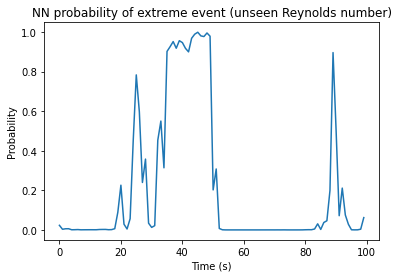

In [10]:
# Evaluation loop

model = PredictEnergyEvent(400)
model.load_state_dict(torch.load(save_model))

re500 = np.load('testdata.npy')
re500 = torch.tensor(re500)

labelsre500 = np.load('labels3.npy')
prediction = model(re500).squeeze()
prediction = prediction.detach().numpy()

plt.plot(prediction)
plt.title("NN probability of extreme event (unseen Reynolds number)")
plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.show()

### Visualization of extreme event for Re = 500

/tmp/ipykernel_1970626/3199246356.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


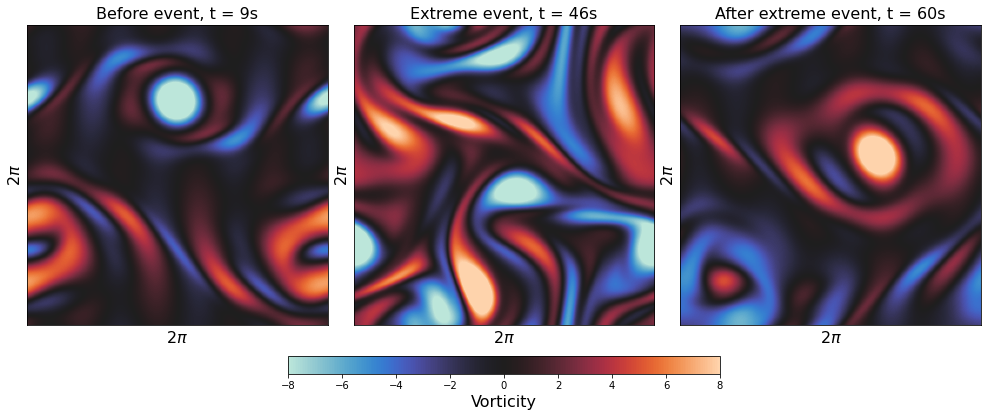

In [13]:
import jax.numpy as jnp 
import seaborn as sns
cols = 3
fig, axs = plt.subplots(1, cols, figsize=(15, 5))

simulation = jnp.load('kolmogorov_Re_500.npy')
data = jnp.fft.irfftn(simulation, axes=(1,2))
time = [9, 46, 60]
labels = ["Before event, t = 9s", "Extreme event, t = 46s", "After extreme event, t = 60s" ]

for i in range(cols):
    timein = time[i]
    im = axs[i].imshow(data[timein], cmap='icefire', vmin=-8, vmax=8)
    axs[i].set_xlabel("$2 \pi$",fontsize=16)
    axs[i].set_ylabel("$2 \pi$", fontsize=16)
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].grid(False)
    axs[i].set_xticks([]) 
    axs[i].set_yticks([]) 
    axs[i].xaxis.set_ticks_position('none')
    
plt.subplots_adjust(bottom=0.5)  
cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Vorticity',fontsize=16)

plt.tight_layout()
plt.show()

### Reinforcement Learning agent for learning optimal controller

See ml/ddpg.py for the script on this work.